This notebook focuses on using GPR (acq. func is EI) to perform BO to determine maximum heat transfer coeff. while doing hyperparameter tuning
1. X -> Viscosity, density, thermal conductivity, heat capacity (thermophysical properties); y -> h
2. Random sampling was done on indices of dataset and then did initial_X, initial_y = X[indices], y[indices]
3. Using initial_X, initial_y, active learning loop was constructed (this is the base code for GPR BO)
4. Comparison with random model was also done towards the end

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI #using EI as acq. function for now; can adjust

import warnings
%matplotlib inline

In [2]:
df = pd.read_excel("dataset/Dataset.xlsx")

In [3]:
df_interest = df[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))', 'Heat Transfer Coefficient']]

In [4]:
X = df_interest[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))']].to_numpy() #full X
y = df_interest['Heat Transfer Coefficient'].to_numpy() #full y

### For one run through GPR for n_iter = 50

In [6]:
from models.models_with_hp import get_h_best, random_sampling, get_rank_best, kernel_tuning

In [7]:
min_vals = np.min(X, axis = 0)
max_vals = np.max(X, axis = 0)
X_norm = (X - min_vals)/(max_vals - min_vals)

In [8]:
indices = np.load('dataset/initial_indices.npy')
indices

array([ 465, 1146,  545,  251,  523, 1023,  425,  683, 1103,  719])

In [9]:
initial_X, initial_y = X_norm[indices], y[indices]

X_pool, y_pool = X_norm.copy(), y.copy()

#### Kernel Tuning

In [10]:
%run ker_hp.py

In [11]:
best_kernel = kernel_tuning (initial_X, initial_y, X_pool, y_pool, kernel_array_stand_alone)
warnings.filterwarnings('ignore')

c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

In [18]:
h_best, h_pred = get_h_best(initial_X, initial_y, X_pool, y_pool, kernel = best_kernel)

Iteration num. 1


In [14]:
kernel_array_stand_alone

[DotProduct(sigma_0=0.01),
 DotProduct(sigma_0=0.0373),
 DotProduct(sigma_0=0.139),
 DotProduct(sigma_0=0.518),
 DotProduct(sigma_0=1.93),
 DotProduct(sigma_0=7.2),
 DotProduct(sigma_0=26.8),
 DotProduct(sigma_0=100),
 Matern(length_scale=0.01, nu=0.5),
 Matern(length_scale=0.01, nu=1.5),
 Matern(length_scale=0.01, nu=2.5),
 Matern(length_scale=0.0373, nu=0.5),
 Matern(length_scale=0.0373, nu=1.5),
 Matern(length_scale=0.0373, nu=2.5),
 Matern(length_scale=0.139, nu=0.5),
 Matern(length_scale=0.139, nu=1.5),
 Matern(length_scale=0.139, nu=2.5),
 Matern(length_scale=0.518, nu=0.5),
 Matern(length_scale=0.518, nu=1.5),
 Matern(length_scale=0.518, nu=2.5),
 Matern(length_scale=1.93, nu=0.5),
 Matern(length_scale=1.93, nu=1.5),
 Matern(length_scale=1.93, nu=2.5),
 Matern(length_scale=7.2, nu=0.5),
 Matern(length_scale=7.2, nu=1.5),
 Matern(length_scale=7.2, nu=2.5),
 Matern(length_scale=26.8, nu=0.5),
 Matern(length_scale=26.8, nu=1.5),
 Matern(length_scale=26.8, nu=2.5),
 Matern(length_sc

In [17]:
h_best_2 = []
iter = 0
for kermel_type in [DotProduct(sigma_0=0.01), Matern(length_scale=7.2, nu=0.5), RBF(length_scale=100), RationalQuadratic(alpha=1.93, length_scale=0.01), WhiteKernel(noise_level=0.139)]:
    h_best_2.append(get_h_best(initial_X, initial_y, X_pool, y_pool, kernel = kermel_type)[0])


Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1


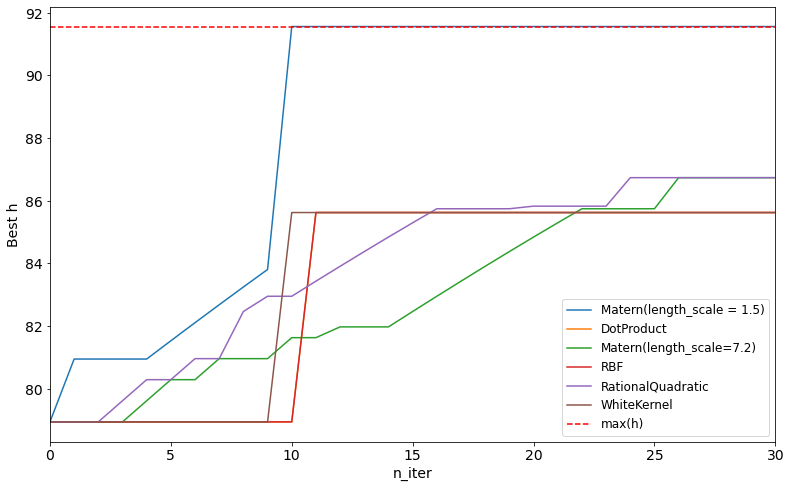

In [25]:
n_iterations = 50

plt.figure(figsize = (13, 8))
plt.plot(h_best)
for kernel_result in h_best_2:
    plt.plot(kernel_result)

plt.plot(np.linspace(0, n_iterations, n_iterations), [np.max(y)]*n_iterations, 'r--')


plt.xlabel('n_iter', fontsize = 14)
plt.ylabel('Best h', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.legend(['Matern(length_scale = 1.5)','DotProduct','Matern(length_scale=7.2)', 'RBF', 'RationalQuadratic', 'WhiteKernel', 'max(h)'], fontsize = 12)
plt.xlim([0, 30])
plt.savefig('figures/kernel_analysis.svg')
plt.show()